In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import pyarrow.parquet

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score, 
                             confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, 
                             balanced_accuracy_score, precision_recall_curve, auc)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [2]:
df_train = pd.read_parquet("00_dataset/without_stopwords/tfidfWithNGram/train_features.parquet")
df_test = pd.read_parquet("00_dataset/without_stopwords/tfidfWithNGram/test_features.parquet")
df_val = pd.read_parquet("00_dataset/without_stopwords/tfidfWithNGram/val_features.parquet")

In [3]:
# Separate into X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

X_val = df_val.drop(columns=["label"])
y_val = df_val["label"]

In [4]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4999,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.194444,0.9611,73,0,0,0.027708,23,0,4.452055
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.187037,0.9422,46,1,0,0.030534,12,0,4.717391
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.147253,0.7906,38,0,0,0.031579,9,0,4.026316
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.253842,0.9874,108,8,0,0.076923,41,0,4.185185
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.257143,0.8903,53,0,0,0.040134,21,0,4.660378


In [4]:
# Feature Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
extracted_features = ['sentiment_score', 'vader_score', 'review_length', 'exclamation_count', 'question_count', 'uppercase_ratio', 'duplicate_word_count', 'emoji_count', 'avg_word_length']

ct_mm = ColumnTransformer(transformers=[('MinMaxScaler', MinMaxScaler(), extracted_features)], remainder='passthrough')
X_train_scaled = ct_mm.fit_transform(X_train)
X_test_scaled = ct_mm.transform(X_test)
X_val_scaled = ct_mm.transform(X_val)

# Save the fitted scaler (Optional: for future use)
joblib.dump(ct_mm, "00_dataset/without_stopwords/tfidfWithNGram/minmax_scaler.joblib")
print("MinMaxScaler saved successfully.")

MinMaxScaler saved successfully.


In [5]:
# Load Min Max Scaler
mms = joblib.load('00_dataset/without_stopwords/tfidfWithNGram/minmax_scaler.joblib')
X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)
X_val_scaled = mms.transform(X_val)

In [6]:
# Check class distribution after split
print("Train Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation Class Distribution:\n", y_val.value_counts(normalize=True))
print("\nTest Class Distribution:\n", y_test.value_counts(normalize=True))

Train Class Distribution:
 label
0    0.867799
1    0.132201
Name: proportion, dtype: float64

Validation Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64

Test Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64


In [6]:
X_train_scaled

array([[0.5972222 , 0.98063934, 0.06336806, ..., 0.        , 0.        ,
        0.        ],
       [0.5935185 , 0.97118413, 0.03993056, ..., 0.        , 0.        ,
        0.        ],
       [0.42637363, 0.89534247, 0.03298611, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.6029514 , 0.9971484 , 0.1467014 , ..., 0.        , 0.        ,
        0.        ],
       [0.73392856, 0.96453047, 0.0390625 , ..., 0.        , 0.        ,
        0.        ],
       [0.5621693 , 0.9788884 , 0.07986111, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [7]:
print("Contains negative values:", np.any(X_train_scaled < 0))


Contains negative values: False


In [10]:
nb = MultinomialNB(fit_prior=True)
nb.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(nb, '00_dataset/without_stopwords/tfidfWithNGram/nb/nb.joblib')
print("Naive Bayes training completed and saved.")

Naive Bayes training completed and saved.


Validation Accuracy: 0.8678

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     52802
           1       0.51      0.00      0.00      8044

    accuracy                           0.87     60846
   macro avg       0.69      0.50      0.47     60846
weighted avg       0.82      0.87      0.81     60846

ROC-AUC Score:  0.7227771827879506


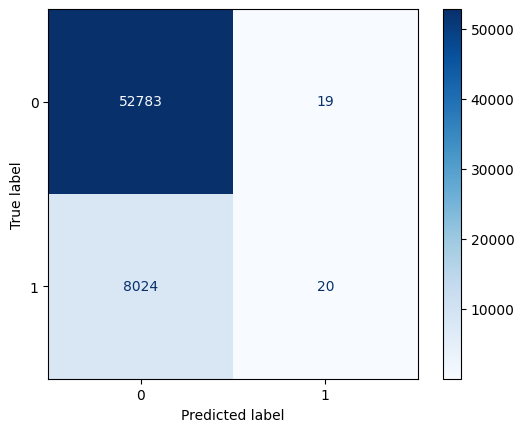

In [11]:
# Load the last saved model
# nb = joblib.load('00_dataset/without_stopwords/tfidfWithNGram/nb/nb.joblib')

# Predict on validation data
y_val_pred = nb.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [8]:
nb = MultinomialNB(class_prior=[0.5, 0.5])
nb.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(nb, '00_dataset/without_stopwords/tfidfWithNGram/nb/classweights_nb.joblib')
print("Naive Bayes training completed and saved.")

Naive Bayes training completed and saved.


Validation Accuracy: 0.6474

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     52802
           1       0.23      0.68      0.34      8044

    accuracy                           0.65     60846
   macro avg       0.58      0.66      0.55     60846
weighted avg       0.84      0.65      0.70     60846

ROC-AUC Score:  0.7227771827879506


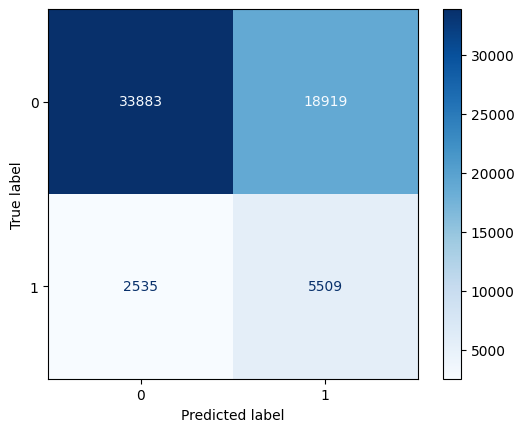

In [9]:
# Load the last saved model
# nb = joblib.load('00_dataset/without_stopwords/tfidfWithNGram/nb/classweights_nb.joblib')

# Predict on validation data
y_val_pred = nb.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

# Apply SMOTE

In [12]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [13]:
# Save SMOTE-transformed dataset
joblib.dump((X_train_smote, y_train_smote), "00_dataset/without_stopwords/tfidfWithNGram/smoteAuto_resampled.joblib")
print("SMOTE-transformed dataset saved successfully.")

SMOTE-transformed dataset saved successfully.


In [14]:
# Check class distribution before and after SMOTE
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_smote).value_counts())

Before SMOTE:
 label
0    369613
1     56307
Name: count, dtype: int64

After SMOTE:
 label
0    369613
1    369613
Name: count, dtype: int64


In [ ]:
nb_smote = MultinomialNB(class_prior=[0.5, 0.5], fit_prior=False)
nb_smote.fit(X_train_smote, y_train_smote)

# Save the model
joblib.dump(nb_smote, '00_dataset/without_stopwords/tfidfWithNGram/smote/nb_smote.joblib')
print("Naive Bayes with SMOTE training completed and saved.")

Naive Bayes with SMOTE training completed and saved.


Validation Accuracy: 0.6988

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.72      0.80     52802
           1       0.24      0.59      0.34      8044

    accuracy                           0.70     60846
   macro avg       0.58      0.65      0.57     60846
weighted avg       0.83      0.70      0.74     60846

ROC-AUC Score:  0.7136434056460537


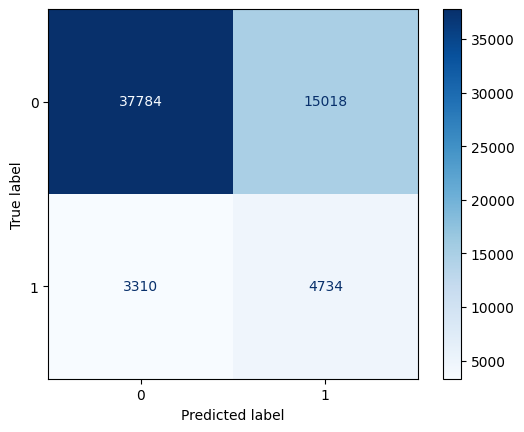

In [16]:
# Load the last saved model
#nb_smote = joblib.load('00_dataset/without_stopwords/tfidfWithNGram/smote/nb_smote.joblib')

# Predict on validation data
y_val_pred = nb_smote.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_smote.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [5]:
smote75 = SMOTE(sampling_strategy=0.75, random_state=42)
X_train_smote75, y_train_smote75 = smote75.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote75, y_train_smote75), "00_dataset/without_stopwords/tfidfWithNGram/smote75_resampled.joblib")
print("SMOTE75-transformed dataset saved successfully.")

SMOTE75-transformed dataset saved successfully.


Naive Bayes with SMOTE75 training completed and saved.
Validation Accuracy: 0.7613

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.85     52802
           1       0.27      0.46      0.34      8044

    accuracy                           0.76     60846
   macro avg       0.59      0.63      0.59     60846
weighted avg       0.82      0.76      0.79     60846

ROC-AUC Score:  0.7153239683351355


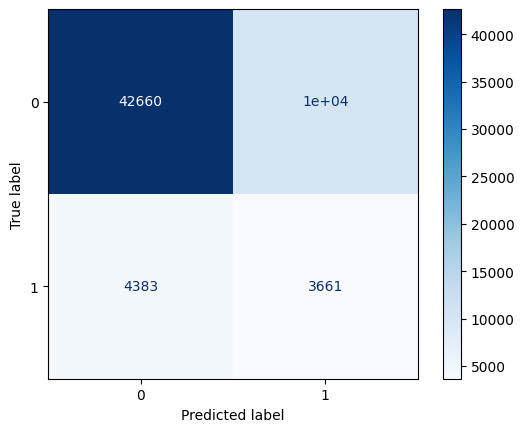

In [6]:
nb_smote75 = MultinomialNB()
nb_smote75.fit(X_train_smote75, y_train_smote75)

# Save the model
joblib.dump(nb_smote75, '00_dataset/without_stopwords/tfidfWithNGram/smote/nb_smote75.joblib')
print("Naive Bayes with SMOTE75 training completed and saved.")

# Predict on validation data
y_val_pred = nb_smote75.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_smote75.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [7]:
smote50 = SMOTE(sampling_strategy=0.50, random_state=42)
X_train_smote50, y_train_smote50 = smote50.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote50, y_train_smote50), "00_dataset/without_stopwords/tfidfWithNGram/smote50_resampled.joblib")
print("SMOTE50-transformed dataset saved successfully.")

SMOTE50-transformed dataset saved successfully.


In [8]:
# Load resampled dataset
X_train_smote50, y_train_smote50 = joblib.load("00_dataset/without_stopwords/tfidfWithNGram/smote50_resampled.joblib")

In [9]:
nb_smote50 = MultinomialNB()
nb_smote50.fit(X_train_smote50, y_train_smote50)

# Save the model
joblib.dump(nb_smote50, '00_dataset/without_stopwords/tfidfWithNGram/smote/nb_smote50.joblib')
print("Naive Bayes with SMOTE50 training completed and saved.")

Naive Bayes with SMOTE50 training completed and saved.


Validation Accuracy: 0.8273

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     52802
           1       0.32      0.26      0.29      8044

    accuracy                           0.83     60846
   macro avg       0.60      0.59      0.59     60846
weighted avg       0.81      0.83      0.82     60846

ROC-AUC Score:  0.7179308027657663


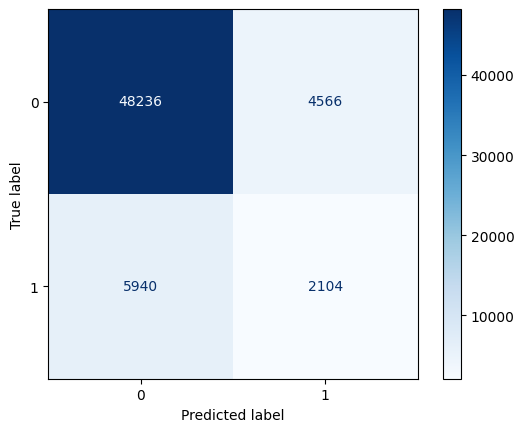

In [10]:
# Load the last saved model
nb_smote50 = joblib.load('00_dataset/without_stopwords/tfidfWithNGram/smote/nb_smote50.joblib')

# Predict on validation data
y_val_pred = nb_smote50.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_smote50.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [11]:
# Load the last saved model
nb_smote50 = joblib.load('00_dataset/without_stopwords/tfidfWithNGram/smote/nb_smote50.joblib')

# Predict on validation data
y_val_pred = nb_smote50.predict(X_val_scaled)
y_proba = nb_smote50.predict_proba(X_val_scaled)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_proba)
mcc = matthews_corrcoef(y_val, y_val_pred)
precision, recall, _ = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall, precision)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Precision-Recall AUC (PR-AUC): {pr_auc:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8273
Balanced Accuracy: 0.5875
ROC-AUC Score: 0.7179
Matthews Correlation Coefficient (MCC): 0.1898
Precision-Recall AUC (PR-AUC): 0.2624

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     52802
           1       0.32      0.26      0.29      8044

    accuracy                           0.83     60846
   macro avg       0.60      0.59      0.59     60846
weighted avg       0.81      0.83      0.82     60846



Validation Accuracy: 0.6472

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77     52802
           1       0.19      0.50      0.27      8044

    accuracy                           0.65     60846
   macro avg       0.54      0.58      0.52     60846
weighted avg       0.80      0.65      0.70     60846

ROC-AUC Score:  0.6221617671497344


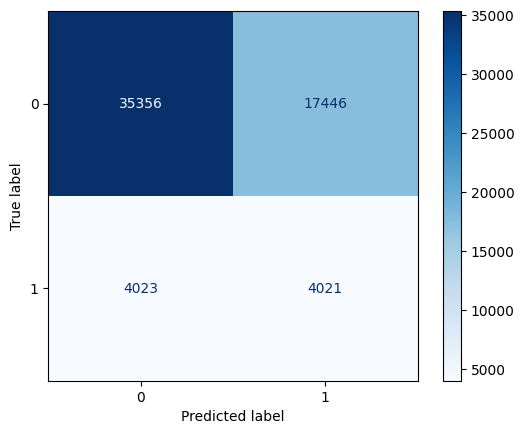

In [ ]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB(alpha=0.1)
cnb.fit(X_train_smote50, y_train_smote50)

# Predict on validation data
y_val_pred = cnb.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = cnb.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [9]:
smote30 = SMOTE(sampling_strategy=0.30, random_state=42)
X_train_smote30, y_train_smote30 = smote30.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote30, y_train_smote30), "00_dataset/without_stopwords/tfidfWithNGram/smote30_resampled.joblib")
print("SMOTE30-transformed dataset saved successfully.")

SMOTE30-transformed dataset saved successfully.


In [10]:
from collections import Counter

# Check class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Check class distribution after SMOTE
print("After SMOTE:", Counter(y_train_smote30))

Before SMOTE: Counter({0: 369613, 1: 56307})
After SMOTE: Counter({0: 369613, 1: 110883})


Naive Bayes with SMOTE30 training completed and saved.
Validation Accuracy: 0.8609

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92     52802
           1       0.37      0.08      0.13      8044

    accuracy                           0.86     60846
   macro avg       0.62      0.53      0.53     60846
weighted avg       0.81      0.86      0.82     60846

ROC-AUC Score:  0.7215655265683828


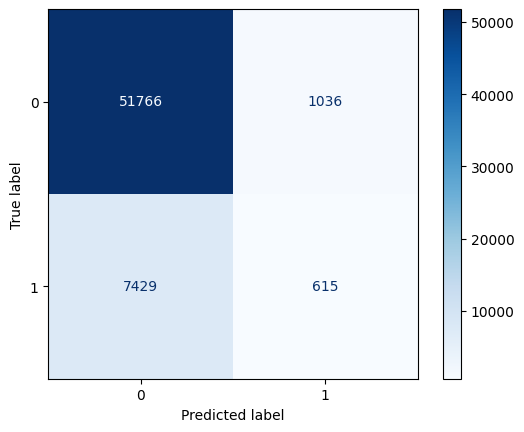

In [5]:
# Load Model
X_train_smote30, y_train_smote30 = joblib.load('00_dataset/without_stopwords/tfidfWithNGram/smote30_resampled.joblib')

nb_smote30 = MultinomialNB()
nb_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(nb_smote30, '00_dataset/without_stopwords/tfidfWithNGram/smote/nb_smote30.joblib')
print("Naive Bayes with SMOTE30 training completed and saved.")

# Predict on validation data
y_val_pred = nb_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

## Using SMOTE 30 to test out for the other models

In [5]:
from collections import Counter

# Load Smote 30
X_train_smote30, y_train_smote30 = joblib.load('smote30_resampled.joblib')

# Check class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Check class distribution after SMOTE
print("After SMOTE:", Counter(y_train_smote30))

Before SMOTE: Counter({0: 369613, 1: 56307})
After SMOTE: Counter({0: 369613, 1: 110883})


### Logistic Regression

In [11]:
# Train Logistic Regression
lr_smote30 = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga', random_state=42, n_jobs=-1)
lr_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(lr_smote30, '00_dataset/without_stopwords/lr_classweights/lr_smote30.joblib')
print("Logistic Regression with SMOTE training completed and saved.")

Logistic Regression with SMOTE training completed and saved.


Validation Accuracy: 0.7225

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.82     52802
           1       0.25      0.57      0.35      8044

    accuracy                           0.72     60846
   macro avg       0.59      0.66      0.59     60846
weighted avg       0.83      0.72      0.76     60846

ROC-AUC Score:  0.7250266203299752


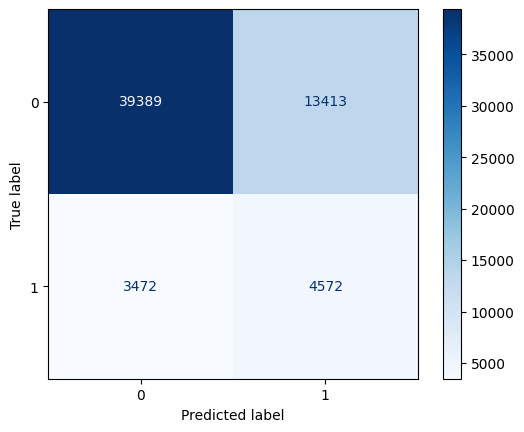

In [12]:
# Load the last saved model
# lr_smote30 = joblib.load('00_dataset/without_stopwords/lr_classweights/lr_smote30.joblib') # Replace X with the last batch number

# Predict on validation data
y_val_pred = lr_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = lr_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

### Random Forest

In [7]:
rf_smote30 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(rf_smote30, '00_dataset/without_stopwords/rf_smote30_classweights/rf_smote30.joblib')
print("Random Forest with SMOTE training completed and saved.")

Random Forest with SMOTE training completed and saved.


Validation Accuracy: 0.8669

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93     52802
           1       0.44      0.03      0.05      8044

    accuracy                           0.87     60846
   macro avg       0.66      0.51      0.49     60846
weighted avg       0.81      0.87      0.81     60846

ROC-AUC Score:  0.6582948714647749


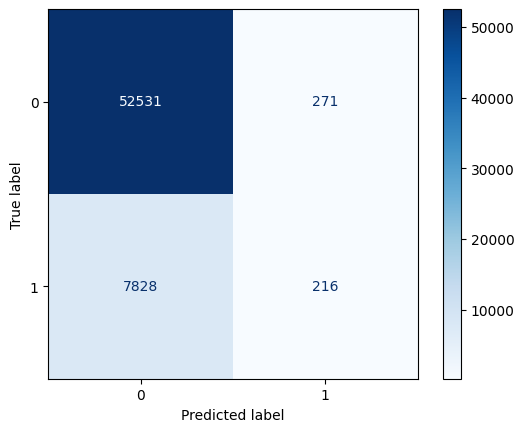

In [8]:
# Predict on validation data
y_val_pred = rf_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = rf_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

### SVM

running for over 500mins 

In [ ]:
svm_smote30 = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(svm_smote30, '00_dataset/without_stopwords/svm_classweights/svm_smote30.joblib')
print("SVM with SMOTE training completed and saved.")

In [ ]:
# Predict on validation data
y_val_pred = svm_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = svm_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

### Adaboost

running for over 700mins --> to try with another model

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
import joblib

# Train AdaBoost with SMOTE 0.3
ab_smote30 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
ab_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(ab_smote30, '00_dataset/without_stopwords/ab_classweights/ab_smote30.joblib')
print("AdaBoost with SMOTE training completed and saved.")

c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# Predict on validation data
y_val_pred = ab_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = ab_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

# Apply SMOTE + Tomek
Adds minority samples (SMOTE) & removes noisy majority samples (Tomek)

In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42, n_jobs=-1)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote_tomek, y_train_smote_tomek), "smotetomek50_resampled.joblib")

SMOTE Tomek will be scrape as it is taking too long to compute. (> 160 mins)

In [ ]:
nb_smote_tomek = MultinomialNB(class_prior=[0.5, 0.5])
nb_smote_tomek.fit(X_train_smote_tomek, y_train_smote_tomek)

# Save the model
joblib.dump(nb_smote_tomek, '00_dataset/without_stopwords/nb_classweights/nb_smote_tomek.joblib')
print("Naive Bayes with SMOTE Tomek training completed and saved.")

In [ ]:
# Load the last saved model
nb_smote_tomek = joblib.load('00_dataset/without_stopwords/nb_classweights/nb_smote_tomek.joblib')

# Predict on validation data
y_val_pred = nb_smote_tomek.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_smote_tomek.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [ ]:
# Train Logistic Regression
lr_smote_tomek = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')
lr_smote_tomek.fit(X_train_smote_tomek, y_train_smote_tomek)

# Save the model
joblib.dump(lr_smote_tomek, '00_dataset/without_stopwords/lr_classweights/lr_smote_tomek.joblib')
print("Logistic Regression with SMOTE Tomek training completed and saved.")

# Apply SMOTE + ENN
SMOTE ENN will be scrape as it is taking too long to compute. (> 100 mins)

In [1]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(sampling_strategy=0.5, random_state=42, n_jobs=-1)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote_enn, y_train_smote_enn), "smoteenn50_resampled.joblib")

NameError: name 'X_train_scaled' is not defined